In [4]:
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.spectra import sensor_spectra, complex_demod_hourly

In [2]:
# ---- load data ----- #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

In [3]:
## --------- compute setup ------------ ##
# time align the 2 sensors
aligned_n = pd.concat([df1['h'].rename('near'), df6['h'].rename('far')], axis=1).dropna()

# instead of a global mean, using a rolling 3 hour mean to track 
# the setup more locally 
tt = '3H'
shore_tt = aligned_n['near'] - aligned_n['near'].rolling(tt, center=True).mean()
far_tt = aligned_n['far'] - aligned_n['far'].rolling(tt, center=True).mean()

n = shore_tt - far_tt


/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_59372/961813477.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  shore_tt = aligned_n['near'] - aligned_n['near'].rolling(tt, center=True).mean()
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_59372/961813477.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  far_tt = aligned_n['far'] - aligned_n['far'].rolling(tt, center=True).mean()


/Users/isidorarojas/Desktop/DIRECTORY/2025/reef_runup/moku_PILOT/2026_Mark_Meetings/../src/spectra.py:325: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=start, end=end, freq='1H')


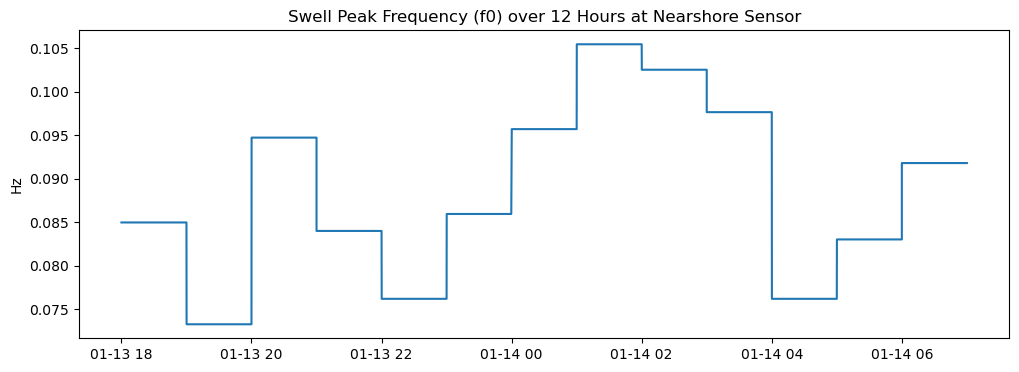

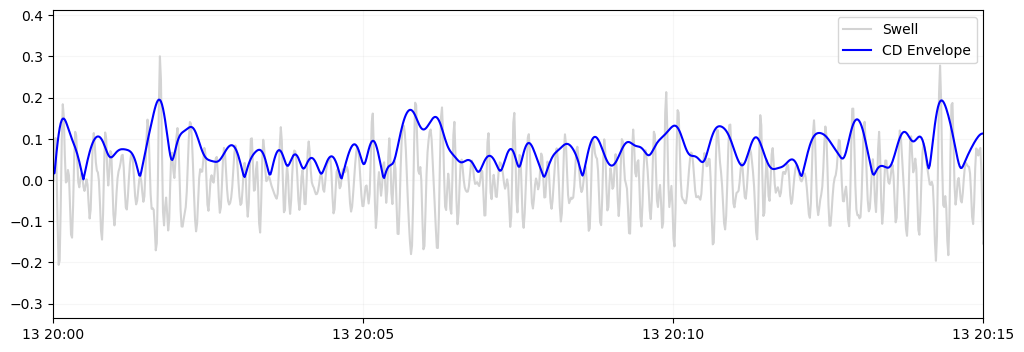

In [7]:
# Run the hourly demod
start = pd.Timestamp("2008-01-13 18:00:00")
end = pd.Timestamp("2008-01-14 06:00:00")
storm_results = complex_demod_hourly(df1, start, end)

# Plot the changing f0 to see the storm evolve
plt.figure(figsize=(12,4))
plt.plot(storm_results.index, storm_results['f0_local'])
plt.title("Swell Peak Frequency (f0) over 12 Hours at Nearshore Sensor")
plt.ylabel("Hz")
plt.show()

# Verification Plot (using stitched hourly data)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(storm_results.index, storm_results['x_ss'], color='lightgray', label='Swell')
ax.plot(storm_results.index, storm_results['A'], color='blue', label='CD Envelope')
plt.xlim(pd.Timestamp("2008-01-13 20:00:00"), pd.Timestamp("2008-01-13 20:15:00"))
plt.legend()
plt.grid(True, alpha=0.1)
plt.show()

In [32]:
## ------Complex Demodulation Function-------- ##


import numpy as np
import pandas as pd
from scipy.signal import spectrogram, butter, filtfilt


def complex_demod_centr(
    df,
    start,
    end,
    p_col="h",
    f_swell=(0.05, 0.2), 
    f_env_max=0.04,      # 0.04 Hz is standard for IG-cutoff
    fs=1.0,
):
    # 1. Subset
    df_win = df.loc[start:end].copy()
    if len(df_win) < 1024: return None

    x = df_win[p_col].to_numpy()

    # Detrend the raw signal before processing to remove tidal drift??
    x = x - np.polyval(np.polyfit(np.arange(len(x)), x, 1), np.arange(len(x)))
    
    t_ns = df_win.index.values.astype('datetime64[ns]').astype(np.int64)
    t_sec = (t_ns - t_ns[0]) / 1e9

    # 17 minute spectral averaging
    # 2. Spectral Centroid Calculation
    f_band = f[mask]
    S_band = S_avg[mask]
    f0 = np.sum(f_band * S_band) / np.sum(S_band)

    # 3. Bandpass (Isolating the Sea/Swell band)
    nyq = 0.5 * fs
    b_bp, a_bp = butter(4, [f_swell[0]/nyq, f_swell[1]/nyq], btype="band")
    x_ss = filtfilt(b_bp, a_bp, x)

    # 4. Demodulate (Thomson & Emery Sec 5.5)
    z_raw = x_ss * np.exp(-1j * 2 * np.pi * f0 * t_sec)

    # 5. Low-pass (Isolating the Envelope)
    # Using your f_env_max (e.g., 0.004Hz for very smooth or 0.04Hz for IG)
    b_lp, a_lp = butter(4, f_env_max/nyq, btype="low")
    z = filtfilt(b_lp, a_lp, z_raw)    

    # 6. Physical Scaling
    A = 2 * np.abs(z)  # Amplitude
    E = A**2           # Energy (Proportional to Radiation Stress)

    return {
        "f0": f0,
        "period": 1/f0,
        "A": pd.Series(A, index=df_win.index),
        "E": pd.Series(E, index=df_win.index),
        "x_ss": x_ss,
        "t": df_win.index
    }

def complex_demod_hourly_centr(
    df,
    start,
    end,
    p_col="h",
    f_swell=(0.05, 0.2),
    f_env_max=0.04,
    fs=1.0
):
    """
    Performs complex demodulation in 1-hour blocks to track 
    shifting carrier frequencies (f0) over time.
    """
    all_results = []
    
    # Create 1-hour bins
    hours = pd.date_range(start=start, end=end, freq='1H')
    
    for h_start in hours:
        h_end = h_start + pd.Timedelta(hours=1)
        
        # Use the logic from complex_demod function
        res = complex_demod_centr(df, h_start, h_end, p_col, f_swell, f_env_max, fs)
        
        if res is not None:
            # Store the local results in a temporary DataFrame
            temp_df = pd.DataFrame({
                'A': res['A'],
                'E': res['E'],
                'x_ss': res['x_ss'],
                'f0_local': res['f0']
            }, index=res['t'])
            all_results.append(temp_df)
            
    if not all_results:
        return None
        
    # Combine everything back into one continuous DataFrame
    final_df = pd.concat(all_results)
    return final_df


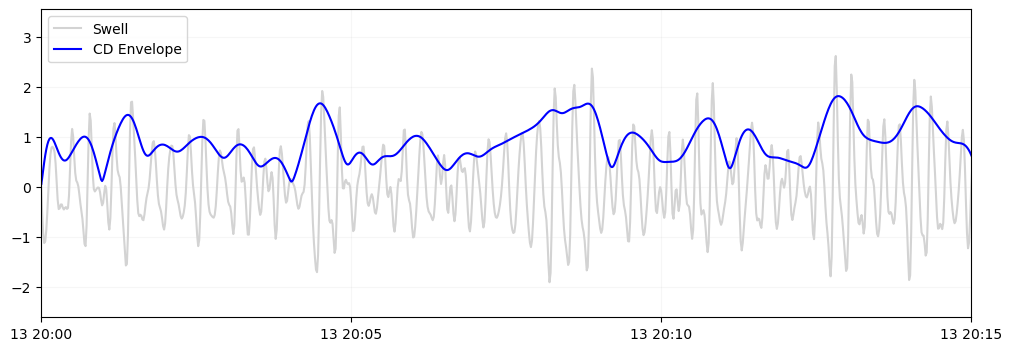

Comparing SS envelopy offshore vs nearshore

In [33]:
start = pd.Timestamp("2008-01-13 18:00:00")
end = pd.Timestamp("2008-01-14 06:00:00")
cd1 = complex_demod_hourly_centr(df1, start, end)
cd6 = complex_demod_centr_hourly(df6, start, end)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(cd1.index, cd1['x_ss'], color='lightgray', label='Swell')
ax.plot(cd1.index, cd1['A'], color='blue', label='CD Envelope')
plt.title('')
plt.xlim(pd.Timestamp("2008-01-13 20:00:00"), pd.Timestamp("2008-01-13 20:15:00"))
plt.legend()
plt.grid(True, alpha=0.1)
plt.show()

/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_59372/1735250808.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=start, end=end, freq='1H')


NameError: name 'f' is not defined